<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in New York City</font></h1>

## Introduction

In this lab, you will learn how to convert addresses into their equivalent latitude and longitude values. Also, you will use the Foursquare API to explore neighborhoods in New York City. You will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. You will use the *k*-means clustering algorithm to complete this task. Finally, you will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt
import seaborn as sns

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

Next, let's load the data.

In [2]:
#filepath = "./Desktop/newyork_data.json"
filepath = "./Documents/DataScience/newyork_data.json"

with open(filepath) as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [3]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [4]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [6]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [12]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
7,Manhattan,East Harlem,40.792249,-73.944182
8,Manhattan,Upper East Side,40.775639,-73.960508
9,Manhattan,Yorkville,40.775930,-73.947118


In [13]:
# Save the data for use in maps once the final neighborhoods are identified after analysis
manhattan_data.to_csv("Manhattan_data.csv")

Let's get the geographical coordinates of Manhattan.

In [14]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.

In [15]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'F1AJUU1UFHUIEB202G545SYM1XW0VMFJWBJODFLWLT2KILTG' # your Foursquare ID
CLIENT_SECRET = '1HFZHUCGQMPT21FECK2I2VCOC4ZPJO5WO50LEII1PTKGVFCJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: F1AJUU1UFHUIEB202G545SYM1XW0VMFJWBJODFLWLT2KILTG
CLIENT_SECRET:1HFZHUCGQMPT21FECK2I2VCOC4ZPJO5WO50LEII1PTKGVFCJ


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [17]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.

In [18]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


In [19]:
CATEGORY_ID_LIST = [
    '4e67e38e036454776db1fb3a', # Residence
    '4bf58dd8d48988d104941735', # Medical Centre
    '5745c2e4498e11e7bccabdbd', # Drugstore
    '4bf58dd8d48988d10f951735', # Pharmacy
    '4f4533804b9074f6e4fb0105', # Elementary School
    '4bf58dd8d48988d13d941735', # High School
    '4f4533814b9074f6e4fb0107', # Nursery School
    '52e81612bcbc57f1066b7a45', # Preschool
    '52e81612bcbc57f1066b7a46', # Private School
    '4d4b7104d754a06370d81259', # Art and Entertainment
#    '4bf58dd8d48988d17f941735', # Movie Theater
#    '4bf58dd8d48988d1e5931735', # Music Venue
#    '4bf58dd8d48988d1f2931735', # Performing Arts Venue
    '52f2ab2ebcbc57f1066b8b4f' # Bus Stop
    '4bf58dd8d48988d1fc931735' # Light Rail Station
    '4bf58dd8d48988d1fd931735' # Metro Station
    '4bf58dd8d48988d129951735' # Train Station
    '52f2ab2ebcbc57f1066b8b51' # Tram Station
    '4bf58dd8d48988d103951735' # Clothing Store
    '4d954b0ea243a5684a65b473' # Convenience Store
    '4bf58dd8d48988d1f9941735', # Food & Drink Shop
    '4bf58dd8d48988d11d941735', # Sports Bar
    '4bf58dd8d48988d11b941735', # Pub
    '4d4b7105d754a06376d81259', # Nightlife Spot
    '4bf58dd8d48988d11f941735', # Nightclub
    '53e510b7498ebcb1801b55d4', # Night Market
    '4bf58dd8d48988d121941735', # Lounge
    '4d4b7105d754a06377d81259', # Outdoors & Recreation
#    '4bf58dd8d48988d175941735', # Gym / Fitness Center
#    '4bf58dd8d48988d163941735', # Park
#    '4bf58dd8d48988d1e7941735', # Playground
    '5744ccdfe4b0c0459246b4c7', # Child Care Service
    '54541900498ea6ccd0202697', # Health & Beauty Service
    '52f2ab2ebcbc57f1066b8b33', # Laundromat
    '4bf58dd8d48988d1fc941735', # Laundry Service
    '4bf58dd8d48988d1fd941735', # Shopping Mall
    '5744ccdfe4b0c0459246b4dc'  # Shopping Plaza
    ]

#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

## 2. Search the Neighborhoods in Manhattan for specific services

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&category_id={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CATEGORY_ID_LIST,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['venues']
         
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [21]:
# type your answer here

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [22]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3706, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Marble Hill Unisex,40.877389,-73.909283,"[{'id': '4bf58dd8d48988d110951735', 'name': 'S..."
1,Marble Hill,40.876551,-73.91066,Wine & Liquors,40.874833,-73.909956,"[{'id': '4bf58dd8d48988d119951735', 'name': 'W..."
2,Marble Hill,40.876551,-73.91066,St. Stephens UMC,40.876967,-73.909106,"[{'id': '4bf58dd8d48988d132941735', 'name': 'C..."
3,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P..."
4,Marble Hill,40.876551,-73.91066,Metro North - Marble Hill Train Station,40.874698,-73.912052,"[{'id': '4bf58dd8d48988d129951735', 'name': 'T..."


In [23]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,98,98,98,98,98,98
Carnegie Hill,100,100,100,100,100,100
Central Harlem,100,100,100,100,100,100
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,85,85,85,85,85,85
East Village,100,100,100,100,100,100


In [24]:
#for index in manhattan_venues.index:
temp_category = pd.DataFrame(list(manhattan_venues['Venue Category'].values)) 

category_name = list()

for index in temp_category.index:
    temp = temp_category[0][index]
    if temp is None:
        category_name.append(np.nan)
    else:    
        temp_name = temp['name']
        category_name.append(''.join(list(temp_name)))

In [25]:
manhattan_venues['Venue Category'] = category_name    

manhattan_venues.head(25)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Marble Hill Unisex,40.877389,-73.909283,Salon / Barbershop
1,Marble Hill,40.876551,-73.91066,Wine & Liquors,40.874833,-73.909956,Wine Shop
2,Marble Hill,40.876551,-73.91066,St. Stephens UMC,40.876967,-73.909106,Church
3,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
4,Marble Hill,40.876551,-73.91066,Metro North - Marble Hill Train Station,40.874698,-73.912052,Train Station
5,Marble Hill,40.876551,-73.91066,St. Johns Roman Catholic Church,40.876174,-73.909795,Church
6,Marble Hill,40.876551,-73.91066,NYCHA - Marble Hill Community Center,40.877135,-73.908061,Housing Development
7,Marble Hill,40.876551,-73.91066,Terrace View Salon,40.876234,-73.912740,Cosmetics Shop
8,Marble Hill,40.876551,-73.91066,The Wall on W225 St,40.874776,-73.911239,Event Space
9,Marble Hill,40.876551,-73.91066,marble hill pharmacy,40.875050,-73.909195,Pharmacy


In [26]:
manhattan_venues.tail(25)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3681,Hudson Yards,40.756658,-74.000111,New York Penn Station,40.750979,-73.993279,Train Station
3682,Hudson Yards,40.756658,-74.000111,Jacob K. Javits Convention Center,40.757140,-74.002404,Convention Center
3683,Hudson Yards,40.756658,-74.000111,Bella Abzug Park,40.755580,-74.000344,Park
3684,Hudson Yards,40.756658,-74.000111,The Vessel,40.753996,-74.002254,Public Art
3685,Hudson Yards,40.756658,-74.000111,Friedman's,40.755271,-73.998509,American Restaurant
3686,Hudson Yards,40.756658,-74.000111,Bolt Bus - W 34 St & 8 Av (Philadelphia/Boston),40.755688,-74.003738,Bus Stop
3687,Hudson Yards,40.756658,-74.000111,Finn’s Bagels,40.756218,-73.997867,Bagel Shop
3688,Hudson Yards,40.756658,-74.000111,Lobby @ 505 West 37,40.757220,-73.998260,Building
3689,Hudson Yards,40.756658,-74.000111,Dunkin',40.756114,-73.997611,Donut Shop
3690,Hudson Yards,40.756658,-74.000111,Manhattan Aquariums,40.757029,-73.999085,Pet Store


Let's check how many venues were returned for each neighborhood

In [27]:
manhattan_venues.dropna(subset = ['Venue Category'], axis=0, inplace=True)

manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,94,94,94,94,94,94
Carnegie Hill,95,95,95,95,95,95
Central Harlem,93,93,93,93,93,93
Chelsea,87,87,87,87,87,87
Chinatown,98,98,98,98,98,98
Civic Center,92,92,92,92,92,92
Clinton,96,96,96,96,96,96
East Harlem,83,83,83,83,83,83
East Village,89,89,89,89,89,89


#### Let's find out how many unique categories can be curated from all the returned venues

In [28]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 378 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [29]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Campaign Office,Candy Store,Caribbean Restaurant,Cemetery,Check Cashing Service,Chinese Restaurant,Chiropractor,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Gym,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Science Building,College Theater,Comedy Club,Community Center,Concert Hall,Conference Room,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corporate Amenity,Corporate Cafeteria,Cosmetics Shop,Coworking Space,Credit Union,Creperie,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Driving School,Dry Cleaner,Dumpling Restaurant,EV Charging Station,Eastern European Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Empanada Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hospital,Hospital Ward,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Laboratory,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Lab,Medical School,Mediterranean Restaurant,Meeting Room,Men's Store,Mental Health Office,Metro Station,Mexican Restaurant,Middle School,Military Base,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mosque,Motel,Mountain,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Nursery School,Office,Opera House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Physical Therap

And let's examine the new dataframe size.

In [30]:
manhattan_onehot.shape

(3433, 379)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Campaign Office,Candy Store,Caribbean Restaurant,Cemetery,Check Cashing Service,Chinese Restaurant,Chiropractor,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Gym,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Science Building,College Theater,Comedy Club,Community Center,Concert Hall,Conference Room,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corporate Amenity,Corporate Cafeteria,Cosmetics Shop,Coworking Space,Credit Union,Creperie,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Driving School,Dry Cleaner,Dumpling Restaurant,EV Charging Station,Eastern European Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Empanada Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hospital,Hospital Ward,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Laboratory,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Lab,Medical School,Mediterranean Restaurant,Meeting Room,Men's Store,Mental Health Office,Metro Station,Mexican Restaurant,Middle School,Military Base,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mosque,Motel,Mountain,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Nursery School,Office,Opera House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Physical Therap

#### Let's confirm the new size

In [32]:
manhattan_grouped.shape

(40, 379)

#### Let's print each neighborhood along with the top 5 most common venues

In [33]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.09
1                             Boat or Ferry  0.07
2                                    Office  0.04
3                                      Park  0.04
4                           Harbor / Marina  0.03


----Carnegie Hill----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.09
1                        Salon / Barbershop  0.07
2                                  Building  0.05
3                               Event Space  0.04
4                        Mexican Restaurant  0.03


----Central Harlem----
                                      venue  freq
0                        Salon / Barbershop  0.12
1  Residential Building (Apartment / Condo)  0.06
2                                  Bus Line  0.04
3                      Gym / Fitness Center  0.03
4                              Cocktail Bar  0.02


----Chelsea----
       

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Residential Building (Apartment / Condo),Boat or Ferry,Park,Office,Food Truck,Harbor / Marina,Building,Bar,Plaza,Church
1,Carnegie Hill,Residential Building (Apartment / Condo),Salon / Barbershop,Building,Event Space,Mexican Restaurant,Laundry Service,Food,Dance Studio,Art Gallery,Italian Restaurant
2,Central Harlem,Salon / Barbershop,Residential Building (Apartment / Condo),Bus Line,Gym / Fitness Center,Deli / Bodega,Juice Bar,Cocktail Bar,Bar,Church,Bus Stop
3,Chelsea,Building,High School,Art Gallery,Laundry Service,Deli / Bodega,Ice Cream Shop,Recreation Center,Café,Furniture / Home Store,Salon / Barbershop
4,Chinatown,Chinese Restaurant,Bus Station,Salon / Barbershop,Bike Shop,Cosmetics Shop,Miscellaneous Shop,Noodle House,Bus Line,Diner,Park


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [36]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
# manhattan_grouped_clustering
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 0, 0, 2, 0, 0, 0, 2])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,0,Deli / Bodega,Salon / Barbershop,High School,Laundry Service,Furniture / Home Store,Residential Building (Apartment / Condo),Church,Office,Housing Development,Nail Salon
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Bus Station,Salon / Barbershop,Bike Shop,Cosmetics Shop,Miscellaneous Shop,Noodle House,Bus Line,Diner,Park
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Residential Building (Apartment / Condo),Building,Doctor's Office,Salon / Barbershop,Bike Shop,Metro Station,Nail Salon,Laundry Service,Rock Club,Miscellaneous Shop
3,Manhattan,Inwood,40.867684,-73.921210,0,Laundry Service,Deli / Bodega,Salon / Barbershop,Nail Salon,Mexican Restaurant,Cosmetics Shop,Pharmacy,Bank,American Restaurant,Food
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Residential Building (Apartment / Condo),Salon / Barbershop,Deli / Bodega,Building,Church,Laundry Service,Non-Profit,Bus Station,Bar,Caribbean Restaurant


Finally, let's visualize the resulting clusters

In [38]:
# create map
f = folium.Figure(width=800, height=400)
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11).add_to(f)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [39]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Deli / Bodega,Salon / Barbershop,High School,Laundry Service,Furniture / Home Store,Residential Building (Apartment / Condo),Church,Office,Housing Development,Nail Salon
1,Chinatown,Chinese Restaurant,Bus Station,Salon / Barbershop,Bike Shop,Cosmetics Shop,Miscellaneous Shop,Noodle House,Bus Line,Diner,Park
3,Inwood,Laundry Service,Deli / Bodega,Salon / Barbershop,Nail Salon,Mexican Restaurant,Cosmetics Shop,Pharmacy,Bank,American Restaurant,Food
5,Manhattanville,Deli / Bodega,Residential Building (Apartment / Condo),College Administrative Building,Office,Building,Salon / Barbershop,Bank,University,Bus Stop,General College & University
6,Central Harlem,Salon / Barbershop,Residential Building (Apartment / Condo),Bus Line,Gym / Fitness Center,Deli / Bodega,Juice Bar,Cocktail Bar,Bar,Church,Bus Stop
7,East Harlem,Residential Building (Apartment / Condo),Pizza Place,Clothing Store,Bus Stop,Bank,Bar,Martial Arts Dojo,Salon / Barbershop,Building,Church
12,Upper West Side,Residential Building (Apartment / Condo),Shoe Store,Pizza Place,Laundry Service,Cosmetics Shop,Nail Salon,Pharmacy,Salon / Barbershop,School,Food Truck
13,Lincoln Square,Theater,High School,Performing Arts Venue,Concert Hall,Building,Plaza,Residential Building (Apartment / Condo),Opera House,Event Space,Library
14,Clinton,Theater,Building,Restaurant,Bus Station,Laundry Service,Bus Line,Concert Hall,General Entertainment,Residential Building (Apartment / Condo),Hotel
17,Chelsea,Building,High School,Art Gallery,Laundry Service,Deli / Bodega,Ice Cream Shop,Recreation Center,Café,Furniture / Home Store,Salon / Barbershop


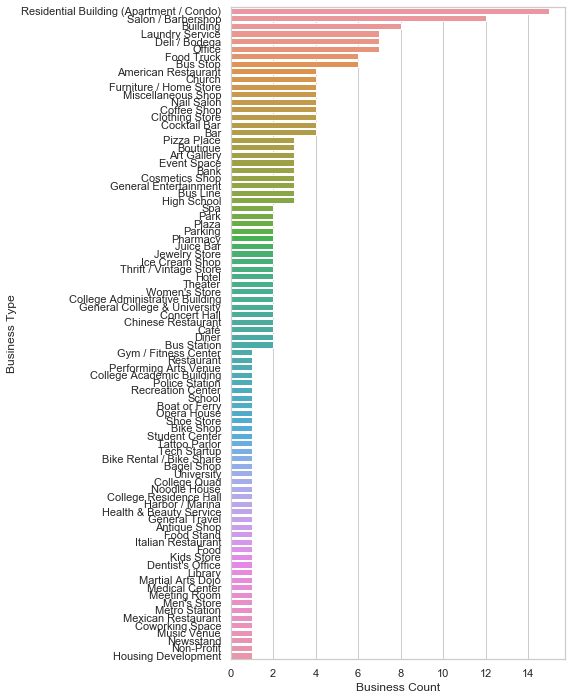

In [40]:
Cluster_1 = pd.DataFrame(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]])
columnNames = ['Business Type']

Cluster_1_count = pd.DataFrame(columns = columnNames)
Cluster_1_count['Business Type'] = pd.concat([Cluster_1['1st Most Common Venue'], Cluster_1['2nd Most Common Venue'], Cluster_1['3rd Most Common Venue'],
                                             Cluster_1['4th Most Common Venue'], Cluster_1['5th Most Common Venue'], Cluster_1['6th Most Common Venue'], 
                                             Cluster_1['7th Most Common Venue'], Cluster_1['8th Most Common Venue'], Cluster_1['9th Most Common Venue'], 
                                              Cluster_1['10th Most Common Venue']], axis =0, ignore_index =True)

Cluster_1_count['Business Count'] = 1
Cluster_1_count.shape


Cluster_1_count = Cluster_1_count.groupby(['Business Type'])['Business Count'].sum().reset_index()
Cluster_1_count = Cluster_1_count.sort_values(by=['Business Count'], ascending=False)

sns.set(style="whitegrid")
plt.subplots(figsize=(6, 12))
ax = sns.barplot(y = "Business Type", x = "Business Count", data=Cluster_1_count)


In [41]:
fig = ax.get_figure()

fig.savefig("NY_Search_Cluster_1.png", bbox_inches = 'tight')

In [42]:
NY_Search_Cluster_1 = set(Cluster_1['Neighborhood'])
print("Neighborhoods in Cluster 1 are: ", NY_Search_Cluster_1)

Neighborhoods in Cluster 1 are:  {'Battery Park City', 'Noho', 'Lincoln Square', 'Chinatown', 'Greenwich Village', 'West Village', 'East Village', 'Manhattanville', 'Upper West Side', 'Inwood', 'Morningside Heights', 'Tribeca', 'Central Harlem', 'Clinton', 'Hudson Yards', 'East Harlem', 'Midtown South', 'Sutton Place', 'Soho', 'Chelsea', 'Marble Hill'}


#### Cluster 2

In [43]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Doctor's Office,Art Gallery,Residential Building (Apartment / Condo),Building,Dentist's Office,Medical Center,Library,Office,Sculpture Garden,High School
16,Murray Hill,Doctor's Office,Residential Building (Apartment / Condo),Dentist's Office,Event Space,Spa,Coworking Space,Coffee Shop,Hotel,Chinese Restaurant,Roof Deck
27,Gramercy,Doctor's Office,Residential Building (Apartment / Condo),Medical Center,Building,Dentist's Office,Salon / Barbershop,Gourmet Shop,Beer Garden,Office,Pharmacy
36,Tudor City,Doctor's Office,Residential Building (Apartment / Condo),Medical Center,Hospital,Building,Gym / Fitness Center,Bus Stop,Laundry Service,Scenic Lookout,Embassy / Consulate


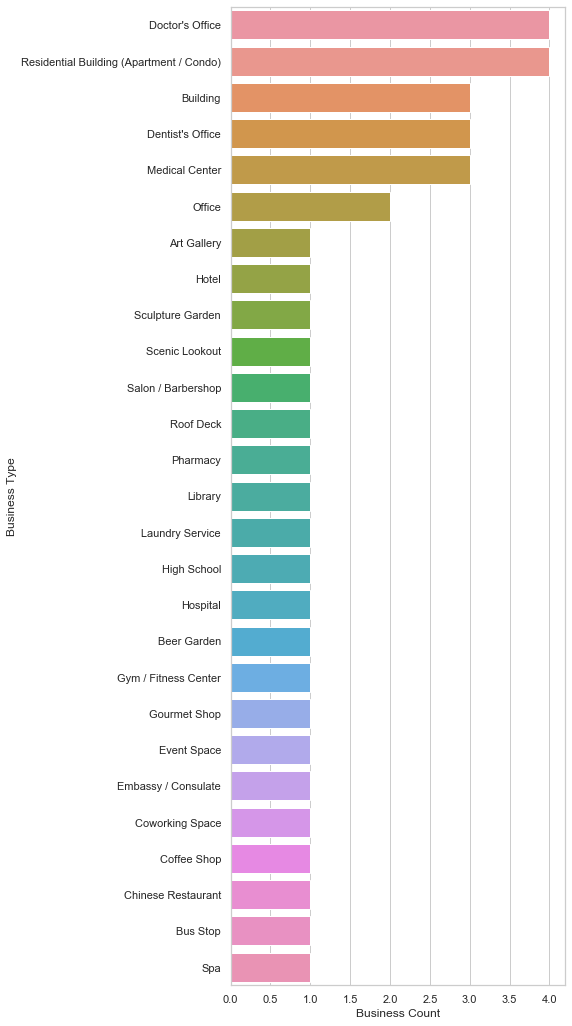

In [44]:
Cluster_2 = pd.DataFrame(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]])
columnNames = ['Business Type']

Cluster_2_count = pd.DataFrame(columns = columnNames)
Cluster_2_count['Business Type'] = pd.concat([Cluster_2['1st Most Common Venue'], Cluster_2['2nd Most Common Venue'], Cluster_2['3rd Most Common Venue'],
                                             Cluster_2['4th Most Common Venue'], Cluster_2['5th Most Common Venue'], Cluster_2['6th Most Common Venue'], 
                                             Cluster_2['7th Most Common Venue'], Cluster_2['8th Most Common Venue'], Cluster_2['9th Most Common Venue'], 
                                              Cluster_2['10th Most Common Venue']], axis =0, ignore_index =True)

Cluster_2_count['Business Count'] = 1
Cluster_2_count.shape


Cluster_2_count = Cluster_2_count.groupby(['Business Type'])['Business Count'].sum().reset_index()
Cluster_2_count = Cluster_2_count.sort_values(by=['Business Count'], ascending=False)

sns.set(style="whitegrid")
plt.subplots(figsize=(6, 18))
ax = sns.barplot(y = "Business Type", x = "Business Count", data=Cluster_2_count)


In [45]:
fig = ax.get_figure()

fig.savefig("NY_Search_Cluster_2.png", bbox_inches = 'tight')

In [46]:
NY_Search_Cluster_2 = set(Cluster_2['Neighborhood'])
print("Neighborhoods in Cluster 2 are: ", NY_Search_Cluster_2)

Neighborhoods in Cluster 2 are:  {'Murray Hill', 'Gramercy', 'Tudor City', 'Upper East Side'}


#### Cluster 3

In [47]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Midtown,Office,General College & University,Building,College Administrative Building,American Restaurant,Shoe Store,Dance Studio,Post Office,Bank,General Entertainment
29,Financial District,Office,Building,Historic Site,Food Truck,Bar,Financial or Legal Service,Event Space,Conference Room,Movie Theater,Juice Bar
32,Civic Center,Office,Coworking Space,Doctor's Office,Government Building,Food Truck,Gym,Lawyer,Convenience Store,Tech Startup,Medical Center
38,Flatiron,Office,Tech Startup,Building,Gym / Fitness Center,Boutique,Sporting Goods Shop,Clothing Store,Furniture / Home Store,Women's Store,Cycle Studio


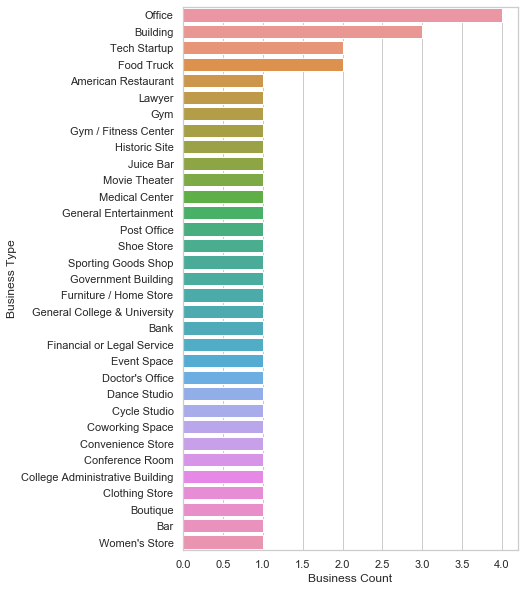

In [48]:
Cluster_3 = pd.DataFrame(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]])
columnNames = ['Business Type']

Cluster_3_count = pd.DataFrame(columns = columnNames)
Cluster_3_count['Business Type'] = pd.concat([Cluster_3['1st Most Common Venue'], Cluster_3['2nd Most Common Venue'], Cluster_3['3rd Most Common Venue'],
                                             Cluster_3['4th Most Common Venue'], Cluster_3['5th Most Common Venue'], Cluster_3['6th Most Common Venue'], 
                                             Cluster_3['7th Most Common Venue'], Cluster_3['8th Most Common Venue'], Cluster_3['9th Most Common Venue'], 
                                              Cluster_3['10th Most Common Venue']], axis =0, ignore_index =True)

Cluster_3_count['Business Count'] = 1
Cluster_3_count.shape


Cluster_3_count = Cluster_3_count.groupby(['Business Type'])['Business Count'].sum().reset_index()
Cluster_3_count = Cluster_3_count.sort_values(by=['Business Count'], ascending=False)

sns.set(style="whitegrid")
plt.subplots(figsize=(6, 10))
ax = sns.barplot(y = "Business Type", x = "Business Count", data=Cluster_3_count)

In [49]:
fig = ax.get_figure()

fig.savefig("NY_Search_Cluster_3.png", bbox_inches = 'tight')

In [50]:
NY_Search_Cluster_3 = set(Cluster_3['Neighborhood'])
print("Neighborhoods in Cluster 3 are: ", NY_Search_Cluster_3)

Neighborhoods in Cluster 3 are:  {'Midtown', 'Flatiron', 'Financial District', 'Civic Center'}


#### Cluster 4

In [51]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,Residential Building (Apartment / Condo),Building,Doctor's Office,Salon / Barbershop,Bike Shop,Metro Station,Nail Salon,Laundry Service,Rock Club,Miscellaneous Shop
4,Hamilton Heights,Residential Building (Apartment / Condo),Salon / Barbershop,Deli / Bodega,Building,Church,Laundry Service,Non-Profit,Bus Station,Bar,Caribbean Restaurant
9,Yorkville,Residential Building (Apartment / Condo),Laundry Service,Spa,Salon / Barbershop,Pharmacy,Gym,Flower Shop,Building,Food & Drink Shop,Construction & Landscaping
10,Lenox Hill,Residential Building (Apartment / Condo),Building,Salon / Barbershop,Art Gallery,Doctor's Office,Nail Salon,Bus Line,Deli / Bodega,Italian Restaurant,Rental Car Location
11,Roosevelt Island,Residential Building (Apartment / Condo),Church,Building,Laundry Service,Rental Car Location,Art Gallery,Playground,Restaurant,Office,Cosmetics Shop
20,Lower East Side,Residential Building (Apartment / Condo),Deli / Bodega,Housing Development,Art Gallery,Building,Bus Station,Bridge,Bike Rental / Bike Share,Church,Diner
25,Manhattan Valley,Building,Deli / Bodega,Salon / Barbershop,Burger Joint,Laundry Service,Spanish Restaurant,Residential Building (Apartment / Condo),Trailer Park,Chinese Restaurant,Grocery Store
30,Carnegie Hill,Residential Building (Apartment / Condo),Salon / Barbershop,Building,Event Space,Mexican Restaurant,Laundry Service,Food,Dance Studio,Art Gallery,Italian Restaurant
35,Turtle Bay,Office,Embassy / Consulate,Government Building,Residential Building (Apartment / Condo),Building,Doctor's Office,Monument / Landmark,Garden,Tunnel,Non-Profit
37,Stuyvesant Town,Residential Building (Apartment / Condo),Playground,Park,Office,Bus Line,Building,Coworking Space,Parking,Gym / Fitness Center,Sporting Goods Shop


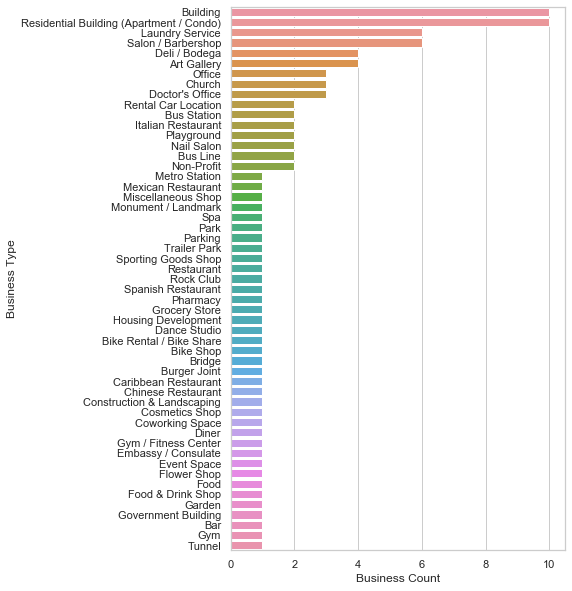

In [52]:
Cluster_4 = pd.DataFrame(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]])
columnNames = ['Business Type']

Cluster_4_count = pd.DataFrame(columns = columnNames)
Cluster_4_count['Business Type'] = pd.concat([Cluster_4['1st Most Common Venue'], Cluster_4['2nd Most Common Venue'], Cluster_4['3rd Most Common Venue'],
                                             Cluster_4['4th Most Common Venue'], Cluster_4['5th Most Common Venue'], Cluster_4['6th Most Common Venue'], 
                                             Cluster_4['7th Most Common Venue'], Cluster_4['8th Most Common Venue'], Cluster_4['9th Most Common Venue'], 
                                              Cluster_4['10th Most Common Venue']], axis =0, ignore_index =True)

Cluster_4_count['Business Count'] = 1
Cluster_4_count.shape


Cluster_4_count = Cluster_4_count.groupby(['Business Type'])['Business Count'].sum().reset_index()
Cluster_4_count = Cluster_4_count.sort_values(by=['Business Count'], ascending=False)

sns.set(style="whitegrid")
plt.subplots(figsize=(6, 10))
ax = sns.barplot(y = "Business Type", x = "Business Count", data=Cluster_4_count)


In [53]:
fig = ax.get_figure()

fig.savefig("NY_Search_Cluster_4.png", bbox_inches = 'tight')

In [54]:
NY_Search_Cluster_4 = set(Cluster_4['Neighborhood'])
print("Neighborhoods in Cluster 4 are: ", NY_Search_Cluster_4)

Neighborhoods in Cluster 4 are:  {'Yorkville', 'Manhattan Valley', 'Turtle Bay', 'Lenox Hill', 'Stuyvesant Town', 'Washington Heights', 'Carnegie Hill', 'Roosevelt Island', 'Hamilton Heights', 'Lower East Side'}


#### Cluster 5

In [55]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Little Italy,Italian Restaurant,Office,Salon / Barbershop,Gift Shop,Gourmet Shop,Cosmetics Shop,Spa,Smoke Shop,Pizza Place,Other Nightlife


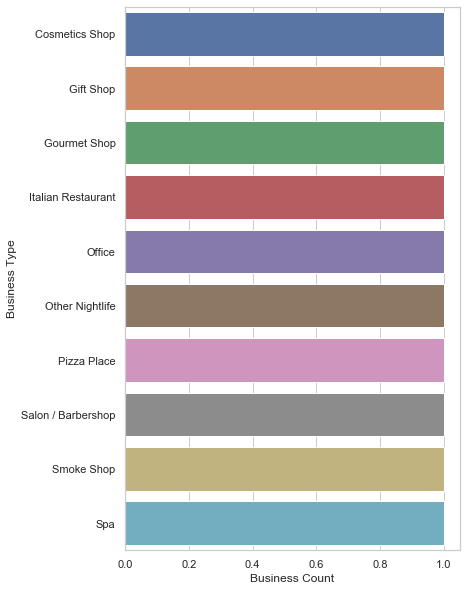

In [56]:
Cluster_5 = pd.DataFrame(manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]])
columnNames = ['Business Type']

Cluster_5_count = pd.DataFrame(columns = columnNames)
Cluster_5_count['Business Type'] = pd.concat([Cluster_5['1st Most Common Venue'], Cluster_5['2nd Most Common Venue'], Cluster_5['3rd Most Common Venue'],
                                             Cluster_5['4th Most Common Venue'], Cluster_5['5th Most Common Venue'], Cluster_5['6th Most Common Venue'], 
                                             Cluster_5['7th Most Common Venue'], Cluster_5['8th Most Common Venue'], Cluster_5['9th Most Common Venue'], 
                                              Cluster_5['10th Most Common Venue']], axis =0, ignore_index =True)

Cluster_5_count['Business Count'] = 1
Cluster_5_count.shape


Cluster_5_count = Cluster_5_count.groupby(['Business Type'])['Business Count'].sum().reset_index()
Cluster_5_count = Cluster_5_count.sort_values(by=['Business Count'], ascending=False)

sns.set(style="whitegrid")
plt.subplots(figsize=(6, 10))
ax = sns.barplot(y = "Business Type", x = "Business Count", data=Cluster_5_count)


In [57]:
fig = ax.get_figure()
fig.savefig("NY_Search_Cluster_5.png" , bbox_inches = 'tight')

In [58]:
NY_Search_Cluster_5 = set(Cluster_5['Neighborhood'])
print("Neighborhoods in Cluster 5 are: ", NY_Search_Cluster_5)

Neighborhoods in Cluster 5 are:  {'Little Italy'}


### Thank you for completing this lab!

This notebook was created by [Alex Aklson](https://www.linkedin.com/in/aklson/) and [Polong Lin](https://www.linkedin.com/in/polonglin/). I hope you found this lab interesting and educational. Feel free to contact us if you have any questions!

This notebook is part of a course on **Coursera** called *Applied Data Science Capstone*. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DP0701EN_Coursera_Week3_LAB2).

<hr>

Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).